In [35]:
import os
import json
import logging
from typing import TypedDict, Annotated, List, Literal, Dict, Any
from uuid import uuid4

# LangChain
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, BaseMessage
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# LangGraph
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

# Pinecone
from pinecone import Pinecone

# env
from dotenv import load_dotenv
load_dotenv()

True

In [36]:
# 상수 설정
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
PINECONE_INDEX_NAME = "talk-assets"

EMBEDDING_MODEL = "text-embedding-3-small"
MODEL_NAME = "gpt-4o"

RULE_FILE_PATH = './data/processed/conversation_rules.json'

In [37]:
# 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

In [38]:
# Pinecone 클라이언트 초기화
pc = Pinecone(api_key=PINECONE_API_KEY)
index = pc.Index(PINECONE_INDEX_NAME)
embeddings = OpenAIEmbeddings(model=EMBEDDING_MODEL)

In [39]:
# 규칙 파일 로드 - 툴 내부에서 사용
with open(RULE_FILE_PATH, 'r', encoding='utf-8') as f:
    CONVERSATION_RULES = json.load(f)

In [40]:
# Tool: 활동 추천
@tool
def recommend_activities(user_emotion: str, mobility_status: str = "거동 가능") -> str:
    """
    사용자의 현재 감정과 거동 상태를 기반으로 기분 전환에 도움이 되는 '활동(Activity)'을 추천합니다.
    사용자가 심심해하거나, 무기력하거나, 무엇을 해야 할지 모른다고 할 때 이 도구를 사용하세요.
    
    Args:
        user_emotion (str): 사용자가 느끼는 현재 감정 (예: '우울하다', '심심하다', '불안하다')
        mobility_status (str): 사용자의 거동 가능 여부 (기본값: '거동 가능')
    """
    logger.info(f"[Tool Call] recommend_activities: {user_emotion}, {mobility_status}")
    
    # 규칙 기반: 감정 -> 태그 매핑
    mappings = CONVERSATION_RULES.get("mappings", {})
    emotion_map = mappings.get("emotion_to_feeling_tags", {})
    mobility_map = mappings.get("mobility_to_energy_range", {})
    
    # 태그 추출 (매칭되는 게 없으면 기본값 설정)
    target_tags = []
    for key, tags in emotion_map.items():
        if key in user_emotion:
            target_tags.extend(tags)
            break
    if not target_tags:
        target_tags = ["평온/이완"]

    # 에너지 레벨 제한 확인
    energy_limit = 5
    for key, limit_info in mobility_map.items():
        if key in mobility_status:
            energy_limit = limit_info.get("max_energy", 5)
            break

    # RAG: Pinecone에서 활동 검색
    # 검색 쿼리 생성 -> 태그를 포함하여 검색
    query_text = f"효과: {', '.join(target_tags)} 인 활동"
    query_vec = embeddings.embed_query(query_text)
    
    # 메타데이터 필터링: 활동(activity) 타입이면서, 에너지 레벨이 허용 범위 내인 것
    search_filter = {
        "type": {"$eq": "activity"},
        "ENERGY_REQUIRED": {"$lte": energy_limit}
    }
    
    results = index.query(
        vector=query_vec,
        top_k=3,
        include_metadata=True,
        filter=search_filter
    )
    
    # 결과 포맷팅
    if not results['matches']:
        return "적절한 추천 활동을 찾지 못했습니다. 해볼만한 활동을 같이 고민해보자고 하거나, 가볍게 산책, 독서, 영화 등을 제안해보세요."
        
    activities = []
    for match in results['matches']:
        meta = match['metadata']
        activities.append(f"- {meta.get('activity_kr', '활동')} (효과: {meta.get('FEELING_TAGS', '')})")
        
    return "추천 활동 목록:\n" + "\n".join(activities)

In [41]:
# Tool: 공감적인 질문
@tool
def search_empathy_questions(user_context: str) -> str:
    """
    대화를 이어가기 위해 사용자에게 건넬 '공감적인 질문'을 찾습니다.
    대화가 막혔거나, 사용자의 속마음을 더 깊이 알아보고 싶을 때 사용하세요.
    
    Args:
        user_context (str): 현재 사용자의 상황이나 발화 내용 요약 (예: '인생의 후회에 대해 이야기 중')
    """
    logger.info(f"[Tool Call] search_empathy_questions: {user_context}")
    
    query_vec = embeddings.embed_query(user_context)
    
    # 메타데이터 필터링: 질문(question) 타입만 검색
    search_filter = {"type": {"$eq": "question"}}
    
    results = index.query(
        vector=query_vec,
        top_k=3,
        include_metadata=True,
        filter=search_filter
    )
    
    if not results['matches']:
        return "유사한 질문이 없습니다. 사용자의 감정에 대해 직접 물어보세요."
        
    questions = []
    for match in results['matches']:
        meta = match['metadata']
        questions.append(f"- {meta.get('question_text', '')} (의도: {meta.get('intent', '')})")
        
    return "참고할 수 있는 질문 예시:\n" + "\n".join(questions)

In [42]:
# 에이전트 및 툴 바인딩
def add_messages(left: List[BaseMessage], right: List[BaseMessage]) -> List[BaseMessage]:
    return left + right

class AgentState(TypedDict):
    # 대화 기록 (LangGraph의 add_messages reducer가 자동 병합 처리)
    messages: Annotated[List[BaseMessage], add_messages]
    # 사용자 프로필 (이름, 나이, 거동상태 등 - 두 모드가 공유하는 메모리)
    user_profile: Dict[str, Any]
    # 현재 활성화된 모드 ('chat' or 'info')
    current_mode: Literal["chat", "info"]

tools = [recommend_activities, search_empathy_questions]

llm = ChatOpenAI(model=MODEL_NAME, temperature=0.7)
llm_with_tools = llm.bind_tools(tools)

In [43]:
# 라우터 노드
# 현재 모드에 따라 다음 노드를 결정하는 라우팅 로직
# (LangGraph의 Conditional Edge에서 사용됨)
def router_node(state: AgentState):
    mode = state.get("current_mode", "chat")
    return mode

# 감성 대화 에이전트
# 사용자의 감정을 읽고 위로하거나, 도구를 사용해 활동/질문을 탐색
def empathy_agent_node(state: AgentState):
    user_profile = state.get("user_profile", {})
    profile_text = ", ".join([f"{k}: {v}" for k, v in user_profile.items()])
    
    system_prompt = f"""
    당신은 사용자의 삶을 회고하고 남은 날들을 의미 있게 보내도록 돕는 'AI 동반자'입니다.
    
    [사용자 프로필]
    {profile_text}
    
    [지침]
    1. 사용자의 말에 깊이 공감하고, 따뜻하고 정중한 어조를 유지하세요.
    2. 해결책을 섣불리 제시하기보다, 감정을 먼저 읽어주세요.
    3. 대화가 끊기거나 깊은 이야기를 유도해야 한다면 `search_empathy_questions` 도구를 사용하세요.
    4. 사용자가 무기력하거나 심심해하면 `recommend_activities` 도구를 사용해 소소한 활동을 제안하세요.
    5. 사용자가 '장례 절차', '법률 정보' 등 객관적 사실을 물어보면, 직접 답하지 말고 "정보 탭에서 정확한 내용을 확인해 드릴까요?"라고 안내하세요.
    """
    
    messages = [SystemMessage(content=system_prompt)] + state["messages"]
    
    # LLM 호출
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [44]:
# 정보 제공 에이전트
def info_agent_node(state: AgentState):
    pass

In [45]:
# 그래프 구축
workflow = StateGraph(AgentState)

# 노드 추가
workflow.add_node("empathy_agent", empathy_agent_node)
workflow.add_node("info_agent", info_agent_node)
workflow.add_node("tools", ToolNode(tools))

# 사용자 입력 -> 모드 확인 -> 해당 에이전트로 이동
def route_by_mode(state: AgentState) -> Literal["empathy_agent", "info_agent"]:
    mode = state.get("current_mode", "chat")
    if mode == "info":
        return "info_agent"
    return "empathy_agent"

workflow.set_conditional_entry_point(
    route_by_mode,
    {
        "empathy_agent": "empathy_agent",
        "info_agent": "info_agent"
    }
)

# Tool 사용 여부 확인
def should_continue(state: AgentState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]

    # 도구 호출이 있으면 tools 노드로 이동
    if last_message.tool_calls:
        return "tools"
    return "__end__"

workflow.add_conditional_edges(
    "empathy_agent",
    should_continue,
    {
        "tools": "tools",
        "__end__": END
    }
)

# Tool 실행 후 다시 Empathy Agent로 복귀 (결과를 보고 답변 생성)
workflow.add_edge("tools", "empathy_agent")

# Info Agent는 현재 바로 종료
workflow.add_edge("info_agent", END)

# 기억을 위한 메모리세이버 & 체크포인터 설정
memory = MemorySaver()

# 그래프 컴파일
app = workflow.compile(checkpointer=memory)

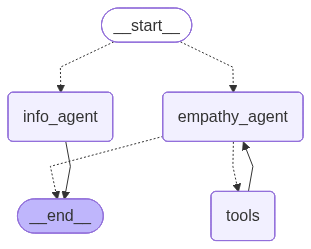

In [46]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [47]:
# 테스트
def run_test_chat(user_name, user_input):
    thread_id = str(uuid4())
    config = {"configurable": {"thread_id": thread_id}}
    
    # 초기 사용자 프로필 설정 (테스트용)
    initial_profile = {
        "name": user_name,
        "age": "70대",
        "mobility": "거동 가능", # recommend_activities에서 사용됨
        "family": "1인 가구"
    }
    print("나: ", user_input)

    # State 주입 (프로필 + 모드 + 메시지)
    inputs = {
        "messages": [HumanMessage(content=user_input)],
        "user_profile": initial_profile,
        "current_mode": "chat"
    }
    
    # 실행
    for event in app.stream(inputs, config=config):
        for key, value in event.items():
            if key == "empathy_agent":
                print(f"[답변]: {value['messages'][-1].content}")
            elif key == "tools":
                print(f"[System]: 도구가 실행되었습니다.")
            print("=" * 50)

    # # 2. 정보 모드 테스트 (메모리가 공유되는지 확인)
    # print("\n------------------------------------------------")
    # print("\n[Mode: Info] 사용자가 탭을 정보 탭으로 바꿨다고 가정합니다.")
    
    # user_input_2 = "장례식장 비용 좀 알려줘."
    # inputs_2 = {
    #     "messages": [HumanMessage(content=user_input_2)],
    #     "user_profile": initial_profile, # 프로필 유지
    #     "current_mode": "info"
    # }
    
    # for event in app.stream(inputs_2, config=config):
    #     for key, value in event.items():
    #         if key == "info_agent":
    #             print(f"\n[AI 답변]: {value['messages'][-1].content}")

In [48]:
user_name = input("이름을 알려주세요: ")

while True:
    user_input = input("사용자 입력: ")
    if user_input == "그만":
        break
    run_test_chat(user_name, user_input)

나:  요즘 무기력해


2025-11-23 01:28:01,206 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 01:28:01,214 - INFO - [Tool Call] recommend_activities: 무기력하다, 거동 가능


[답변]: 


2025-11-23 01:28:02,934 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


[System]: 도구가 실행되었습니다.


2025-11-23 01:28:06,638 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[답변]: 요즘 무기력하다고 느끼시는군요. 그런 감정은 누구나 느낄 수 있는 자연스러운 것이에요. 기분 전환에 도움이 될 수 있는 몇 가지 활동을 추천드릴게요:

- **일기 쓰기**: 하루의 작은 일들을 기록하면서 성취감과 자기 성찰의 시간을 가져보세요.
- **레시피 적어두기**: 좋아하는 요리나 새로운 레시피를 적어보는 것도 좋은 방법이에요. 성취감을 느낄 수 있답니다.
- **감사 편지 쓰기**: 주변의 소중한 사람들에게 감사의 마음을 전해보는 건 어떨까요? 마음이 따뜻해지고 사회적 연결감을 느낄 수 있을 거예요.

이러한 활동들이 조금이나마 도움이 되었으면 좋겠어요. 혹시 다른 이야기도 나누고 싶으시면 언제든지 말씀해 주세요.
